author: @SteveEckel

This example covers calculating the forces in a one-dimensional optical molasses
using the optical bloch equations.  It attempts to reproduce several figures 
from Ungar, P. J., Weiss,
D. S., Riis, E., & Chu, S. "Optical molasses and multilevel atoms:
theory." *Journal of the Optical Society of America B*, **6** 2058 (1989).
http://doi.org/10.1364/JOSAB.6.002058

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp
import scipy.constants as cts
import lmfit
savefigs = True

### Put infrastructure in place:

First, the reference is for sodium, so let's get the mass parameter for $^{23}$Na:

In [2]:
atom = pylcp.atom('23Na')
mass = (atom.state[2].gamma*atom.mass)/(cts.hbar*(100*2*np.pi*atom.transition[1].k)**2)
print(mass)

195.87538720801354


In [3]:
def return_hamiltonian(Fl, Delta):
    Hg, Bgq = pylcp.hamiltonians.singleF(F=Fl, gF=0, muB=1)
    He, Beq = pylcp.hamiltonians.singleF(F=Fl+1, gF=1/(Fl+1), muB=1)
    dijq = pylcp.hamiltonians.dqij_two_bare_hyperfine(Fl, (Fl+1))
    hamiltonian = pylcp.hamiltonian(Hg, -Delta*np.eye(He.shape[0])+He, Bgq, Beq, dijq, mass=mass)
    
    return hamiltonian

# Now, make 1D laser beams:
def return_lasers(delta, beta, pol):
    if pol[0][2]>0 or pol[0][1]>0:
        pol_coord = 'spherical'
    else:
        pol_coord = 'cartesian'

    return pylcp.laserBeams([
        {'kvec':np.array([0., 0., 1.]), 'pol':pol[0],
         'pol_coord':pol_coord, 'delta':delta, 'beta':beta},
        {'kvec':np.array([0., 0., -1.]), 'pol':pol[1],
         'pol_coord':pol_coord, 'delta':delta, 'beta':beta},
        ], beam_type=pylcp.infinitePlaneWaveBeam)

# Now make a bunch of polarization keys:
pols = {'$\\sigma^+\\sigma^-$':[np.array([0., 0., 1.]), np.array([1., 0., 0.])],
        '$\\sigma^+\\sigma^+$':[np.array([0., 0., 1.]), np.array([0., 0., 1.])]}
    
phi = [0, np.pi/2]
phi_keys = ['$\phi=0$', '$\phi=\pi/2$']
for phi_i, key_beam in zip(phi, phi_keys):
        pols[key_beam] = [np.array([1., 0., 0.]), np.array([np.cos(phi_i), np.sin(phi_i), 0.])]

## Let's make a basic force profile

This is not contained in the reference, but let's do it anyway.  We start
by creating, using our special functions defined above, a set of lasers, 
a magnetic field, a Hamiltonian, and then the set of optical Bloch equations.

In [4]:
det = -2.0
beta = 0.5

laserBeams = return_lasers(0., beta, pol=pols['$\\sigma^+\\sigma^-$'])

magField = pylcp.constantMagneticField(np.array([0., 0., 0.]))

hamiltonian = return_hamiltonian(2, det)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                include_mag_forces=False, transform_into_re_im=True)

Next, we run the force profile:

In [5]:
v = np.concatenate((np.arange(0.0, 0.1, 0.01),
                    np.arange(0.1, 5.1, 0.1)))

obe.generate_force_profile(
    [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
    [np.zeros(v.shape), np.zeros(v.shape), v],
     name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
     progress_bar=True,
)

Completed in 1:19.                                                  


Finally, we plot it up:

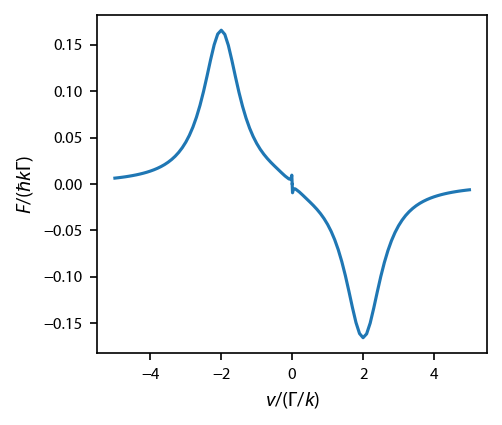

In [6]:
fig, ax = plt.subplots(1, 1)
ax.plot(np.concatenate((-v[::-1], v)),
         np.concatenate((-obe.profile['molasses'].F[2][::-1],
                        obe.profile['molasses'].F[2]))
        )
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

if savefigs:
    fig.savefig('')

## Next, let's reproduce Figure 6

This force compares the various polarizations.  To make it, we first make each OBE individually, and save the resulting forces.
Note that in Ungar, they define their velocity scale through $m v_0^2 = \hbar\Gamma$, resulting in forces in terms of $M v_0 \Gamma$.  Compared 
to us, they measure their velocities in terms of

$$
\frac{v_0}{k/\Gamma} = \sqrt{\frac{\hbar\Gamma}{m}}\frac{k}{\Gamma} =  \sqrt{\frac{\hbar k^2}{\Gamma m}} = \sqrt{\bar{m}}
$$

Likewise, the force ratio,

$$
\frac{M v_0 \Gamma}{\hbar k \Gamma} = \frac{M\sqrt{\hbar\Gamma}}{\hbar k} = \sqrt{\frac{M\Gamma}{\hbar k^2}} = \sqrt{\bar{m}}
$$

In [7]:
det = -2.73
beta = 1.25

v = np.concatenate((np.array([0.0]), np.logspace(-2, np.log10(4), 20)))/np.sqrt(mass)

keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$',
                    '$\phi=0$', '$\phi=\pi/2$']

F = {}
for key in keys_of_interest:
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)

    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                    transform_into_re_im=True)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*1000, deltat_v=4, itermax=10,
        progress_bar=True
    )
    
    F[key] = obe.profile['molasses'].F[2]

Completed in 6:37.                                                  
Completed in 3:43.                                                  
Completed in 7:26.                                                  
Completed in 7:59.                                                  


Plot it up.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


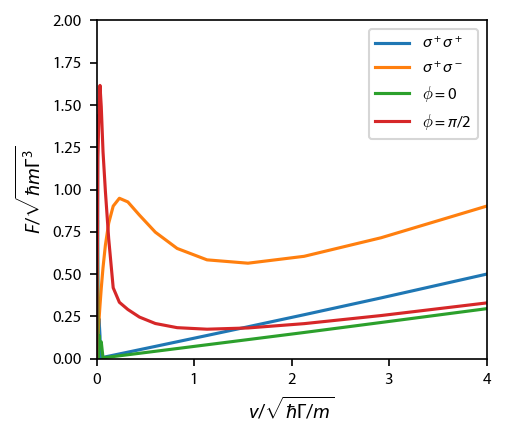

In [8]:
fig, ax = plt.subplots(1, 1, num="Forces; F=2 to F=3")
for key in keys_of_interest:
    ax.plot(v*np.sqrt(mass), -1e3*F[key]/np.sqrt(mass), label=key)
ax.set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax.set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax.legend(fontsize=8)
ax.set_xlim((0, 4.))
ax.set_ylim((0, 2.))

if savefigs:
    fig.savefig('ungar_fig_6.pdf')

## Figure 7

Compare the two-level vs. the corkscrew at large velocities.

In [ ]:
v = np.concatenate((np.arange(0, 1.5, 0.2),
                    np.arange(0.2, 50., 1.5)))/np.sqrt(mass)

beta = 1.25
det = -2.73

keys_of_interest = ['$\\sigma^+\\sigma^+$', '$\\sigma^+\\sigma^-$']

F = {}
for key in keys_of_interest:
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)
    
    obe = pylcp.obe(laserBeams, magField, hamiltonian,
                    transform_into_re_im=True)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )
    
    F[key] = obe.profile['molasses'].F[2]

Plot it up

In [ ]:
fig, ax = plt.subplots(1, 1)
for key in keys_of_interest:
    ax.plot(v*np.sqrt(mass), -1e3*F[key]/np.sqrt(mass), label=key)
ax.set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax.set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax.set_ylim((0, 25))
ax.set_xlim((0, 50))
ax.legend(fontsize=8)

if savefigs:
    fig.savefig('ungar_fig_7.pdf')

## Figure 8

We run the detuning and saturation parameter for the corkscrew model.

In [ ]:
dets = [-1.0, -1.37, -2.73]
betas = [0.5, 1.25, 2.5]
key = '$\\sigma^+\\sigma^-$'

v = np.arange(0.0, 1.025, 0.025)/np.sqrt(mass)
F_dets = [None]*3
for ii, det in enumerate(dets):
    laserBeams = return_lasers(0., betas[1], pol=pols[key])
    hamiltonian = return_hamiltonian(2, det)

    obe = pylcp.obe(laserBeams, magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )
    
    F_dets[ii] = obe.profile['molasses'].F[2]

F_betas = [None]*3
for ii, beta in enumerate(betas):
    laserBeams = return_lasers(0., beta, pol=pols[key])
    hamiltonian = return_hamiltonian(2, dets[-1])

    obe = pylcp.obe(laserBeams, magField, hamiltonian)

    obe.generate_force_profile(
        [np.zeros(v.shape), np.zeros(v.shape), np.zeros(v.shape)],
        [np.zeros(v.shape), np.zeros(v.shape), v],
        name='molasses', deltat_tmax=2*np.pi*100, deltat_v=4, itermax=1000,
        progress_bar=True
    )

    F_betas[ii] = obe.profile['molasses'].F[2]

Plot it up:

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(3.25, 2*2.75))
for (F, det) in zip(F_dets, dets):
    ax[0].plot(v*np.sqrt(mass), -1e3*F/np.sqrt(mass), label='$\delta = %f' % det)
for (F, beta) in zip(F_betas, betas):
    ax[1].plot(v*np.sqrt(mass), -1e3*F/np.sqrt(mass), label='$\beta = %f' % beta)
ax[1].set_xlabel('$v/\sqrt{\hbar\Gamma/m}$')
ax[0].set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax[0].set_ylim((0, 6))
ax[0].set_xlim((0, 1))
ax[1].set_ylabel('$F/\sqrt{\hbar m \Gamma^3}$')
ax[1].set_ylim((0, 2))
ax[1].set_xlim((0, 1))

ax[0].xaxis.set_ticklabels('')

fig.subplots_adjust(bottom=0.01, hspace=0.05)

if savefigs:
    fig.savefig('ungar_fig_8.pdf')

## Now, let's run a simulation of many atoms and find the temperature:

We start with just a single atom just to make sure everything is OK.

In [ ]:
tmax = 1e4
det = -2.73
beta = 1.25
key =  '$\\sigma^+\\sigma^-$'

laserBeams = return_lasers(0., beta, pol=pols[key])
hamiltonian = return_hamiltonian(2, det)

obe = pylcp.obe(laserBeams, magField, hamiltonian,
                include_mag_forces=False)
    
obe.set_initial_position(np.array([0., 0., 0.]))
obe.set_initial_velocity(np.array([0., 0., 0.]))
obe.set_initial_rho_equally()

obe.evolve_motion(
    [0, tmax],
    t_eval=np.linspace(0, tmax, 501),
    random_recoil=True,
    progress_bar=True,
    max_scatter_probability=0.5,
    record_force=True,
    freeze_axis=[True, True, False]
)

Plot up the test simulation:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6.5, 2.75))
ll = 0
styles = ['-', '--', '-.']
for jj in range(3):
    ax[0].plot(obe.sol.t/1e3,
               obe.sol.v[jj], styles[jj],
               color='C%d'%ll, linewidth=0.75)
    ax[1].plot(obe.sol.t/1e3,
               obe.sol.r[jj],
               styles[jj], color='C%d'%ll, linewidth=0.75)

#ax[1].set_ylim(-5., 5.)
ax[0].set_ylabel('$v_i/(\Gamma/k)$')
ax[1].set_ylabel('$k r_i$')
ax[0].set_xlabel('$10^{3} \Gamma t$')
ax[1].set_xlabel('$10^{3} \Gamma t$')
fig.subplots_adjust(left=0.1, wspace=0.22)

Plot up the force experienced by the atom during this short duration of time.

### Now run a big yuge sim:

Non-parallel version:
    
```
sols = []
for jj in range(Natoms):
    trap.set_initial_position(np.array([0., 0., 100.]))
    trap.set_initial_velocity(0.0*np.random.randn(3))
    
    trap.evolve_motion([0, 3e2], 
                       t_eval=np.linspace(0, 1e2, 1001),
                       random_recoil=True,
                       recoil_velocity=v_R,
                       progress_bar=True,
                       max_scatter_probability=0.5,
                       record_force=True)
    
    sols.append(copy.copy(trap.sol))
```

In [ ]:
import pathos, time
from pylcp.common import progressBar
if hasattr(obe, 'sol'):
    del obe.sol
    
t_eval = np.linspace(0, tmax, 5001)

def generate_random_solution(x, tmax=1e4):
    # We need to generate random numbers to prevent solutions from being seeded
    # with the same random number.
    np.random.rand(256*x)
    obe.set_initial_position(np.array([0., 0., 0.]))
    obe.set_initial_velocity(np.array([0., 0., 0.]))
    obe.set_initial_rho_equally()
    obe.evolve_motion(
        [0, tmax],
        t_eval=t_eval,
        random_recoil=True,
        max_scatter_probability=0.5,
        record_force=True,
        freeze_axis=[True, True, False]
    )
    
    return obe.sol

Natoms = 96
chunksize = 4
sols = []
progress = progressBar()
for jj in range(int(Natoms/chunksize)):
    with pathos.pools.ProcessPool(nodes=4) as pool:
        sols += pool.map(generate_random_solution, range(chunksize))
    progress.update((jj+1)/int(Natoms/chunksize))

Now, plot 'er up:

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6.25, 2.75))

for sol in sols:
    ax[0].plot(sol.t*atom.state[1].tau*1e3,
               sol.v[2], linewidth=0.25)
    ax[1].plot(sol.t*atom.state[1].tau*1e3,
               sol.r[2]/(2*np.pi*0.1*atom.transition[1].k), linewidth=0.25)

for ax_i in ax:
    ax_i.set_xlabel('$t$ (ms)')
ax[0].set_ylabel('$v_z/(\Gamma/k)$')
ax[1].set_ylabel('$z$ (mm)')
    
fig.subplots_adjust(left=0.1, bottom=0.08, wspace=0.25)
if savefigs:
    fig.savefig('random_dynamics_F2_to_F3_molasses.pdf')

One interesting result from the Unager paper is to look at the average force as a function of position and velocity for the random particles.

In [ ]:
allv = np.concatenate([sol.v.T for sol in sols]).T
allF = np.concatenate([sol.F.T for sol in sols]).T

v = np.arange(-.003, 0.003, 0.0001)
vc = v[:-1]+np.mean(np.diff(v))/2

avgFv = np.zeros((3, 3, vc.size))
stdFv = np.zeros((3, 3, vc.size))

for jj in range(3):
    for ii, (v_l, v_r) in enumerate(zip(v[:-1],v[1:])):
        inds = np.bitwise_and(allv[jj] <= v_r, allv[jj] > v_l)
        if np.sum(inds)>0:
            for kk in range(3):
                avgFv[kk, jj, ii] = np.mean(allF[kk, inds])
                stdFv[kk, jj, ii] = np.std(allF[kk, inds])
        else:
            avgFv[:, jj, ii] = np.nan
            avgFv[:, jj, ii] = np.nan
                          
fig, ax = plt.subplots(1, 1)
ax.plot(vc, 1e3*avgFv[2, 2], linewidth=0.75)
ax.set_xlabel('$v_z$')
ax.set_ylabel('$F/(\hbar k \Gamma)$')

if savefigs:
    fig.savefig('forces_experienced_random_evolution_F1_to_F2_obe.pdf')

Let's evaluate the temperature as a function of time:

In [ ]:
vs = np.nan*np.zeros((3, len(sols), len(t_eval)))
for ii, sol in enumerate(sols):
    vs[:, ii, :] = sol.v
    
sigma_v = np.std(vs[2], axis=0)

fig, ax = plt.subplots(1, 1)
ax.plot(t_eval*atom.state[1].tau*1e3, 2*sigma_v.T**2*hamiltonian.mass)
ax.axhline(1, color='k', linestyle='--')
ax.set_ylabel('$T/T_D$')
ax.set_xlabel('$t$ (ms)')

print('Temperature %.2f uK' % (np.mean(2*sigma_v[-1000:]**2*hamiltonian.mass)*cts.hbar*atom.state[2].gamma/2/cts.k*1e6))